<a href="https://colab.research.google.com/github/mattrosenblatt7/leakage_neuroimaging/blob/main/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import multiprocessing
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from scipy.stats import spearmanr
import glob
from matplotlib.ticker import FormatStrFormatter
import re
import colorcet as cc


In [ ]:
def calc_quantile(x, q):
    '''
    Compute quantile of data
    '''
    return x.quantile(q)


def two_line_text(txt):
    '''
    Function to place text onto two rows for axis or title labels
    '''

    words = txt.split(' ')
    word_lengths = [len(w)+1 for w in words]
    mid_loc = np.argmin(np.abs(np.cumsum(word_lengths) / np.sum(word_lengths)-0.5))
    words[mid_loc]+='\n'
    return ' '.join(words).replace('\n ', '\n')

# Main results

In [ ]:
df_all = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/all_results.csv')
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                     right_on=['leakage_type', 'dataset', 'pheno'])

# NEW: change attention to attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)


df_all = df_all.sort_values('leakage_type')

Compare to gold standard

In [ ]:
# group by pheno and dataset to get gold standard table
df_table_gold = df_all[df_all.leakage_type=='gold'].groupby(['pheno', 'dataset'], as_index=False)\
    .agg(rmed=('r', 'median'), r2_5=('r', lambda x: calc_quantile(x, 0.025)),
         r97_5=('r', lambda x: calc_quantile(x, 0.975)),
         q2med=('q2', 'median'), q2_2_5=('q2', lambda x: calc_quantile(x, 0.025)),
         q2_97_5=('q2', lambda x: calc_quantile(x, 0.975)) )

# add in median values from OTHER leakage types to gold-standard table
all_leakage_types = df_all[df_all.leakage_type!='gold'].leakage_type.unique()
for l in all_leakage_types:
    df_tmp = df_all[df_all.leakage_type==l].groupby(['pheno', 'dataset'], as_index=False)\
    .agg(rmed=('r', 'median'),
         q2med=('q2', 'median') )

    # merge other leakage types into gold dataframe, adding a suffix with leakage type to the var name
    df_table_gold = df_table_gold.merge(df_tmp, how='left',
                    left_on=['pheno', 'dataset'], right_on=['pheno', 'dataset'],
                   suffixes=('', '_' + l))

df_table_gold = df_table_gold.rename(columns={'rmed':'rmed_gold', 'q2med':'q2med_gold'})
df_table_gold.head(20)

,pheno,dataset,rmed_gold,r2_5,r97_5,q2med_gold,q2_2_5,q2_97_5,rmed_gold_minus_covars,q2med_gold_minus_covars,...,rmed_leak_feature,q2med_leak_feature,rmed_leak_site,q2med_leak_site,rmed_leak_subj_10,q2med_leak_subj_10,rmed_leak_subj_20,q2med_leak_subj_20,rmed_leak_subj_5,q2med_leak_subj_5
0,age,abcd,0.254238,0.246005,0.263275,0.063101,0.058289,0.068535,0.246438,0.059089,...,0.298150,0.088710,0.245186,0.058351,0.281914,0.079098,0.302720,0.091602,0.269407,0.071803
1,age,hbn,0.758323,0.751264,0.764788,0.574424,0.563762,0.583775,0.765230,0.584611,...,0.779835,0.607667,0.758441,0.574493,0.781733,0.609382,0.802249,0.641386,0.771480,0.594055
2,age,hcpd,0.797999,0.788514,0.809352,0.628965,0.614145,0.651208,0.860962,0.740708,...,0.829487,0.683751,0.798629,0.629588,0.817281,0.662834,0.837350,0.696977,0.807322,0.643897
3,age,pnc,0.642230,0.626246,0.656936,0.412403,0.392048,0.431200,0.679417,0.461254,...,0.729228,0.531497,NaN,NaN,0.681173,0.463564,0.712989,0.506818,0.663881,0.440623
4,ap,abcd,0.126349,0.114241,0.133795,0.002326,-0.003763,0.006326,0.165165,0.019797,...,0.190750,0.035202,0.119175,-0.000614,0.165999,0.019990,0.194531,0.033699,0.146711,0.011141
5,ap,hbn,-0.011990,-0.051871,0.038767,-0.211833,-0.254055,-0.161980,0.032729,-0.173718,...,0.510589,0.260458,-0.009098,-0.211168,0.166739,-0.071405,0.278847,0.028430,0.087980,-0.136427
6,ap,hcpd,0.014263,-0.046087,0.074597,-0.128069,-0.200635,-0.070754,0.061069,-0.204480,...,0.484012,0.223037,0.018151,-0.117614,0.186282,-0.023087,0.290327,0.060041,0.109502,-0.064679
7,ap,pnc,0.017058,-0.019314,0.048486,-0.151391,-0.212458,-0.099585,0.036135,-0.174334,...,0.450725,0.201722,NaN,NaN,0.168371,-0.056992,0.285228,0.033804,0.093626,-0.110262
8,mr,abcd,0.247667,0.240028,0.256039,0.056965,0.052349,0.062472,0.254218,0.061783,...,0.280134,0.078383,0.243237,0.054440,0.279554,0.076161,0.303217,0.091251,0.264625,0.067265
9,mr,hbn,0.290950,0.267192,0.308682,0.083484,0.067965,0.095061,0.340793,0.083142,...,0.384394,0.134969,0.286037,0.080311,0.337546,0.113922,0.371080,0.136993,0.316555,0.099946


In [ ]:
'''
Use this for printing out changes in performance relative to gold for specific phenotypes/datasets
'''
pheno = ['mr', 'ap', 'attn']
datasets = ['abcd', 'hbn', 'pnc', 'hcpd']
df_table_gold_pheno = df_table_gold[(df_table_gold.pheno.isin(pheno)) & (df_table_gold.dataset.isin(datasets))]
for l in all_leakage_types:

    # print actual r/q2
#     print('r: ' + l + ': {:.4f}'.format(
#         (df_table_gold_pheno['q2med_' + l].median())))

    print('r: ' + l + ' min change: {:.4f} and max change: {:.4f}'.format(
        (df_table_gold_pheno['rmed_' + l] - df_table_gold_pheno['rmed_gold']).min(),
        (df_table_gold_pheno['rmed_' + l] - df_table_gold_pheno['rmed_gold']).max()
    ))

    print('q2: ' + l + ' min change: {:.4f} and max change: {:.4f}'.format(
        (df_table_gold_pheno['q2med_' + l] - df_table_gold_pheno['q2med_gold']).min(),
        (df_table_gold_pheno['q2med_' + l] - df_table_gold_pheno['q2med_gold']).max()
    ))

    print('*******************************************************')

r: gold_minus_covars min change: 0.0066 and max change: 0.0503
q2: gold_minus_covars min change: -0.0764 and max change: 0.0381
*******************************************************
r: gold_minus_site min change: -0.0014 and max change: 0.0240
q2: gold_minus_site min change: 0.0038 and max change: 0.0147
*******************************************************
r: gold_minus_site_covars min change: 0.0259 and max change: 0.0701
q2: gold_minus_site_covars min change: -0.0793 and max change: 0.0473
*******************************************************
r: leak_covars min change: -0.0920 and max change: -0.0054
q2: leak_covars min change: -0.1701 and max change: -0.0035
*******************************************************
r: leak_family min change: 0.0009 and max change: 0.0184
q2: leak_family min change: 0.0003 and max change: 0.0046
*******************************************************
r: leak_feature min change: 0.0325 and max change: 0.5226
q2: leak_feature min change: 0.0214 an

Plotting histograms

In [ ]:
# sort it for right ordering
sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3, 'gold_zscore':4,
            'leak_zscore':5, 'leak_feature':6, 'leak_site':7, 'leak_covars':8, 'leak_family':9,
            'leak_subj_5':10, 'leak_subj_10':11, 'leak_subj_20':12}
# rename dictionary
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}

leakage_types_all = ['Gold standard',
                 'No covariate regression', 'No site correction',
                 'No site or covariate', 'Z-score phenotype',
                 'Leaky feature selection',
                'Leaky z-score',
                'Leaky site correction', 'Leaky covariate regression',
                 'Family leakage', 'Subject leakage (5%)',
                'Subject leakage (10%)', 'Subject leakage (20%)'

                ]


# color palette dictionary based on names
pal_all = ['black']
np.random.seed(4)
cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity
pal_all.extend([cmap_tmp[color_idx] for color_idx in color_shuffle_idx])
pal_dict = dict(zip(leakage_types_all, pal_all))

gold_zscore
leak_zscore


<ipython-input-8-10eeec8e32aa>:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


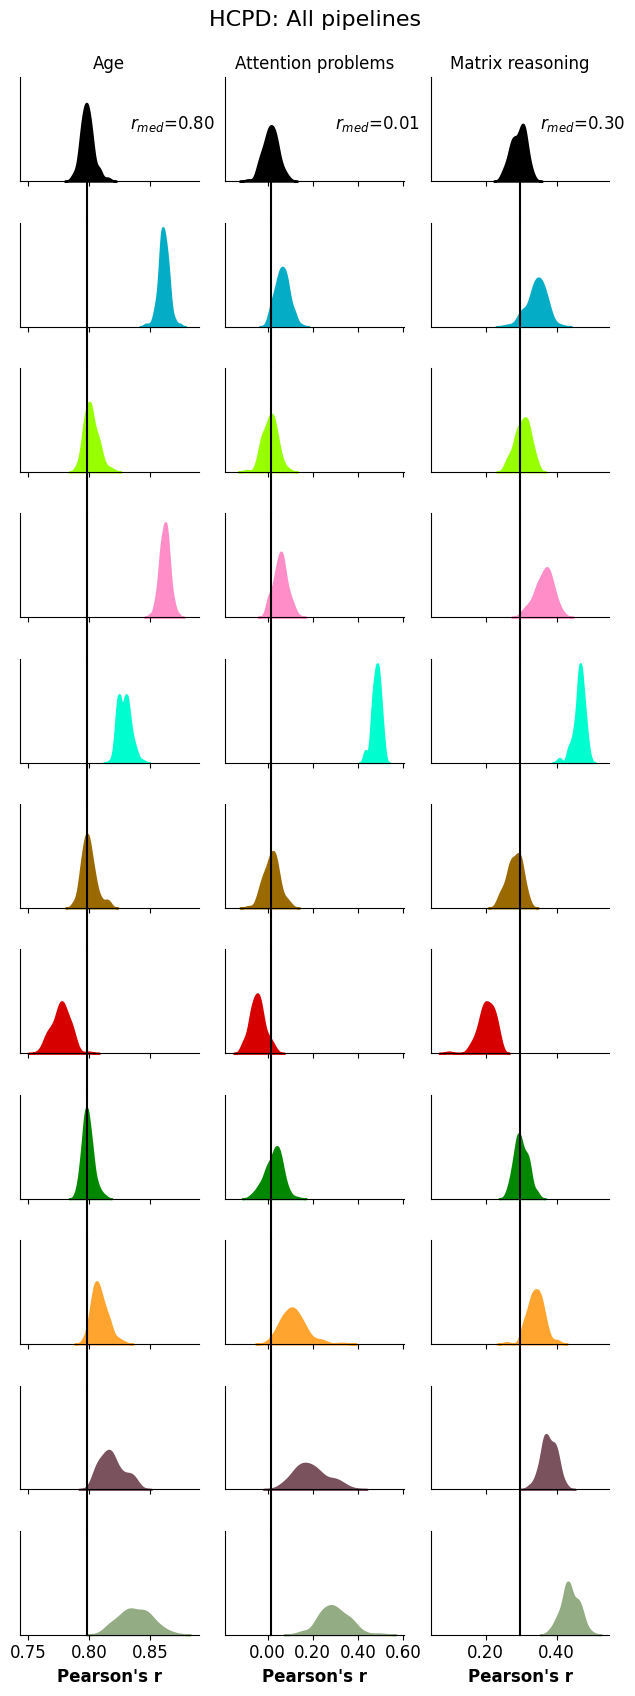

In [ ]:
'''
Plots for any combination of dataset/phenotype
you can modify these below:
-r_or_q2: choices ['r', 'q2']
-dataset: choices ['abcd', 'hbn', 'hcpd', 'pnc]
-leakage_cat: choices ['All pipelines', 'Feature leakage', 'Subject-level leakage', 'Covariate-related leakage', 'Non-leaky analysis chocies']
'''

r_or_q2 = 'q2'
pheno = 'mr'
dataset = 'hcpd'
for r_or_q2 in ['r']:
    for dataset in ['hcpd']:
        for leakage_cat in ['All pipelines']:

            '''
            Copy below for all
                            'All pipelines',
                            'Feature leakage',
                            'Subject-level leakage',
                            'Covariate-related leakage',
                           'Non-leaky analysis choices'
            '''

            if dataset=='abcd':
                ylab = True
            else:
                ylab = False

            ylab = False

            df_plot = df_all[(df_all.dataset==dataset)]

            # add in missing keys
            all_leakage_types = [k for k in sort_dict.keys()]
            for k in sort_dict.keys():
                if k not in df_plot.leakage_type.unique():
                    print(k)
                    df_tmp = pd.DataFrame(np.nan, index=[0], columns=df_plot.keys())
                    df_tmp['dataset'] = dataset
                    df_tmp['pheno'] = pheno
                    df_tmp['leakage_type'] = k
                    df_tmp['r'] = df_plot.r.mean()
                    df_tmp['med_r'] = np.nan
                    df_tmp['q2'] = df_plot.q2.mean()
                    df_tmp['med_q2'] = np.nan
                    df_plot = pd.concat([df_plot, df_tmp])

            # sort it
            df_plot = df_plot.reset_index(drop=True)
            df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


            # rename
            df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)




            if leakage_cat=='Feature leakage':
                leakage_types = ['Gold standard', 'Leaky feature selection']
            elif leakage_cat=='Subject-level leakage':
                leakage_types = ['Gold standard', 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)']
            elif leakage_cat=='Covariate-related leakage':
                leakage_types = ['Gold standard',
                                'Leaky site correction', 'Leaky covariate regression']
            elif leakage_cat=='Non-leaky analysis choices':
                leakage_types = ['Gold standard', 'No covariate regression', 'No site correction',
                                 'No site or covariate']
            elif leakage_cat=='All pipelines':
                leakage_types = ['Gold standard',
                                 'No covariate regression', 'No site correction',
                                 'No site or covariate',
                                 'Leaky feature selection',
                                'Leaky site correction', 'Leaky covariate regression',
                                 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)'

                                ]


            # restrict plot df to just leakage types of interest
            df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

            df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

            ###################################### Actual plotting ######################################
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

            # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
            if leakage_cat=='Feature leakage':
                plot_aspect = 2.5
                plot_height = 1.25
                fontsize=12
            elif (leakage_cat=='All pipelines') & ( (dataset!='hcpd') | (r_or_q2=='r') ):
                plot_aspect = 1.5
                plot_height = 1.5
                fontsize=12
            elif (leakage_cat=='All pipelines') & (dataset=='hcpd') & (r_or_q2=='q2'):
                plot_aspect = 3
                plot_height = 1.5
                fontsize = 12
            else:
                plot_aspect = 4
                plot_height = 0.75
                fontsize=12

            g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                              aspect=plot_aspect, height=plot_height,
                              col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                              row_order=leakage_types,
                              sharex='col', sharey='col',palette=pal,)

            # then we add the densities kdeplots
            g.map(sns.kdeplot, r_or_q2,
                  bw_adjust=1, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)

            # adjust plot spacing
            if leakage_cat=='All pipelines':
                g.fig.subplots_adjust(hspace=0.4, wspace=0.15)
            else:
                g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


            for row_idx, ax_col in enumerate(g.axes):
                nrows = len(g.axes)
                for col_idx, ax in enumerate(ax_col):

                    # if in first column and relevant datasets, set ylabel
                    if (col_idx==0) & (((dataset=='hcpd') & (leakage_cat!='All pipelines'))\
                                       | ((dataset=='hcpd') & (r_or_q2=='q2')) | (dataset=='abcd')):
                        leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                        leakage_type_str = two_line_text(leakage_type_str)
                        ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

                    else:
                        ax.set_ylabel('')

                    # if in first row, set title
                    pheno_str = ax.title.get_text().split('=')[-1].strip()
                    if row_idx==0:
                        ax.set_title(pheno_str, fontsize=fontsize)
                    else:
                        ax.set_title('')

                    # other formatting specifications
                    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
                    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax.set_yticks([])

                    # for last row
                    if r_or_q2=='r':
                        xlab = "Pearson's r"
                    else:
                        xlab = "$q^2$"
                    ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

                    # vertical line - the mean doesn't do anything since it's one value anyways
                    gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                         (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
                    if row_idx==0:
                        ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
                    elif row_idx==(nrows-1):
                        ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
                    else:
                        ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

                    # add text to axis with median r (gold_value)
                    if row_idx==0:
                        if leakage_cat=='Covariate-related leakage':
                            xloc = 0.21
                            yloc = 0.55
                        elif leakage_cat=='All pipelines':
                            xloc = 0.85
                            yloc = 0.55
                        else:
                            xloc = 0.89
                            yloc = 0.55

                        if r_or_q2=='r':
                            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)
                        elif r_or_q2=='q2':
                            ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)


            # add in dataset title
            mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
            g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), leakage_cat),
                           ha='center',
                           va='top',
                           fontsize=fontsize+4,
                           fontweight=20,
                           x=mid, y=1.02)

Ranked summary boxplot

In [ ]:
# merge gold-standard into df_all
df_gold = df_all[df_all.leakage_type=='gold'].reset_index()
df_all_withgold = df_all[df_all.leakage_type!='gold'].merge(df_gold[['pheno', 'dataset', 'seed', 'r', 'q2']], how='left',
             left_on=['pheno', 'dataset', 'seed'], right_on=['pheno', 'dataset', 'seed'],
             suffixes=('', '_gold'))

# compare to gold standard performance
df_all_withgold['r_diff'] = df_all_withgold['r'] - df_all_withgold['r_gold']
df_all_withgold['q2_diff'] = df_all_withgold['q2'] - df_all_withgold['q2_gold']


# rename
rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}
df_all_withgold['leakage_type'] = df_all_withgold.leakage_type.replace(rename_dict)

<ipython-input-10-6598575f859b>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


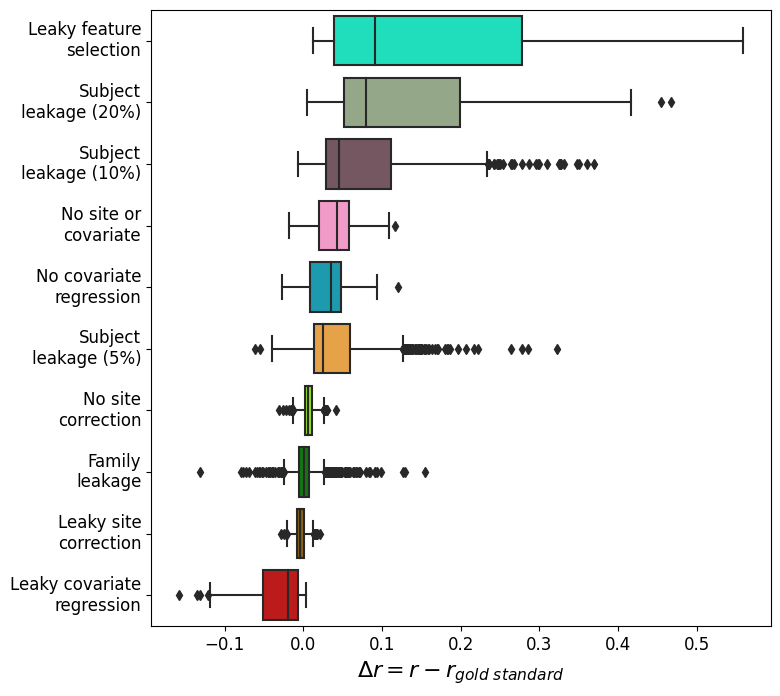

In [ ]:
'''
Change below to plot for r or q2 metric
This will make boxplots of performance difference between leaky analysis and "gold standard" across all datasets/phenotypes
'''
r_or_q2 = 'r'  # 'r', 'q2'

fig, ax = plt.subplots(figsize=(8, 8))

# rank leakage types by median difference over gold standard
leakage_diff_ranks = list(df_all_withgold.groupby(['leakage_type'], as_index=False).\
                          agg(r_diff_med=('r_diff', 'median'),
                             q2_diff_med=('q2_diff', 'median')).\
                          sort_values(by=r_or_q2+'_diff_med', ascending=False)['leakage_type'])
leakage_type_str = [two_line_text(l) for l in leakage_diff_ranks]

# colors
# palette based on smaller dataframe
pal = [pal_dict[l] for l in leakage_diff_ranks]

sns.boxplot(data=df_all_withgold, y='leakage_type', x=r_or_q2+'_diff',
            order=leakage_diff_ranks, ax=ax, palette=pal)

# this is if wanting label for both r and q2
if r_or_q2=='r':
    ax.set_xlabel('$\Delta r = r - r_{gold \ standard}$', fontsize=16)
elif r_or_q2=='q2':
    ax.set_xlabel('$\Delta q^2 = q^2 - q^2_{gold \ standard}$', fontsize=16)
ax.set_yticklabels(leakage_type_str, fontsize=12, rotation=0, ha='right', va='center')

ax.set_ylabel('')
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)


Coefficient plots

<ipython-input-11-288a2834b69f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)
<ipython-input-11-288a2834b69f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)
<ipython-input-11-288a2834b69f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

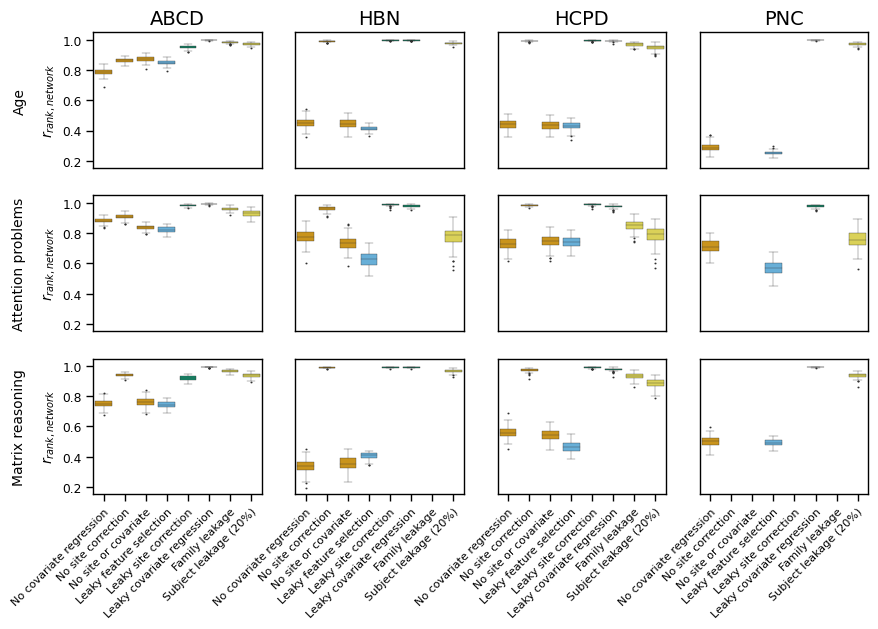

In [ ]:
# plots for coefficients, can either be r_coef or spearman rank between network counts for feature selection

coloring_type = 'leakage_family'  # '' or 'leakage_family'

plot_type = 'spearman_network_feat'  # r_coef, spearman_network_feat

pheno_all = ['age', 'ap', 'mr']
dataset_all = ['abcd', 'hbn', 'hcpd', 'pnc']
sns.set_context('paper')

# sort it for right ordering
all_leakage_types = [k for k in sort_dict.keys()]


npheno = len(pheno_all)
ndataset = len(dataset_all)
fig, axs = plt.subplots(nrows=npheno, ncols=ndataset, figsize=(10, 6))
for row_idx, pheno in enumerate(pheno_all):
    for col_idx, dataset in enumerate(dataset_all):

        df_plot = df_all[(df_all.pheno==pheno) & (df_all.dataset==dataset)]

        # rename columns
        df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)



        leakage_types = ['No covariate regression', 'No site correction',
                         'No site or covariate', 'Leaky feature selection',
                        'Leaky site correction', 'Leaky covariate regression',
                        'Family leakage', 'Subject leakage (20%)']

        # restrict plot df to just leakage types of interest
        df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

        df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

        ###################################### Actual plotting ######################################
        if coloring_type=='leakage_family':
            # updated palette by leakage type:
            # see https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230072B2-%23D55E00-%23CC79A7
            pal = ['#E69F00', '#E69F00', '#E69F00',
                  '#56B4E9',
                  '#009E73', '#009E73',
                  '#F0E442','#F0E442']
        else:
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

        # new way: boxplot
        sns.boxplot(data=df_plot, x='leakage_type', y=plot_type, ax=axs[row_idx, col_idx],
                   palette=pal, order=leakage_types,
                    linewidth=0.25, fliersize=0.5)

        if plot_type=='spearman_network_feat':
            axs[row_idx, col_idx].set_ylim([0.15, 1.05])
        else:
            axs[row_idx, col_idx].set_ylim([0.25, 1.05])

        if row_idx == (npheno-1):
            axs[row_idx, col_idx].set_xlabel('Leakage type')
            axs[row_idx, col_idx].set_xticklabels(axs[row_idx, col_idx].get_xticklabels(), rotation=45,
                                                  ha='right', fontsize=8, rotation_mode="anchor")
            axs[row_idx, col_idx].set_xlabel('')
        else:
            axs[row_idx, col_idx].set_xlabel('')
            axs[row_idx, col_idx].set_xticks([])

        if row_idx==0:
            axs[row_idx, col_idx].set_title(dataset.upper(), fontsize=14)

        if col_idx == 0:
            if plot_type=='spearman_network_feat':
                axs[row_idx, col_idx].set_ylabel('$r_{rank,network}$', fontsize=10)
            elif plot_type=='r_coef':
                axs[row_idx, col_idx].set_ylabel('$r_{coef}$', fontsize=10)

            # add y label
            if pheno=='ap':
                y_lab_bigtext = 'Attention problems'
            elif pheno=='age':
                y_lab_bigtext = 'Age'
            elif pheno=='mr':
                y_lab_bigtext = 'Matrix reasoning'

            # adjust y label location based on which plot type
            if plot_type=='spearman_network_feat':
                yloc = 0.6
            else:
                yloc = 0.65

            axs[row_idx, col_idx].text(-4, yloc, y_lab_bigtext,
                                       rotation=90, ha='center', va='center',fontsize=10)
        else:
            axs[row_idx, col_idx].set_ylabel('')
            axs[row_idx, col_idx].set_yticks([])



In [ ]:
'''
Group dataframe to find similarity of coefficients across different leakage types etc.
'''
leakage_type_tmp = 'leak_covars'
coef_type = 'spearman_network_feat'  # r_coef, spearman_network_feat
df_coef_grouped = df_all.groupby(['leakage_type', 'pheno', 'dataset'], as_index=False).agg(coef_similarity_med=(coef_type, 'median'))
df_coef_grouped[df_coef_grouped.leakage_type==leakage_type_tmp].sort_values(by='coef_similarity_med')

,leakage_type,pheno,dataset,coef_similarity_med
48,leak_covars,ap,hcpd,0.978136
49,leak_covars,ap,pnc,0.979426
52,leak_covars,mr,hcpd,0.979571
47,leak_covars,ap,hbn,0.982184
51,leak_covars,mr,hbn,0.991423
53,leak_covars,mr,pnc,0.993119
46,leak_covars,ap,abcd,0.993497
44,leak_covars,age,hcpd,0.993902
50,leak_covars,mr,abcd,0.994183
43,leak_covars,age,hbn,0.997051


Sample size data

In [ ]:
# load sample size data
df_all = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/sample_size_results.csv')
df_all['r_diff'] = df_all['r'] - df_all['r_gold']

# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

df_all.head()

,pheno,dataset,sample_size,resample_seed,perfeat,kfold_seed,leakage_type,r,q2,r_yp,r_gold,r_diff
0,age,abcd,200,7,0.05,4,leak_covars,-0.034614,-0.185931,0.964720,-0.055269,0.020655
1,mr,abcd,200,8,0.05,1,leak_covars,-0.084184,-0.128087,0.730056,-0.022325,-0.061860
2,mr,pnc,400,9,0.05,2,leak_covars,0.200813,-0.013702,0.924519,0.228257,-0.027444
3,ap,hcpd,200,4,0.05,6,leak_covars,-0.023377,-0.234875,0.805910,-0.010887,-0.012490
4,age,pnc,400,3,0.05,4,leak_covars,0.573489,0.326034,0.987994,0.575091,-0.001601


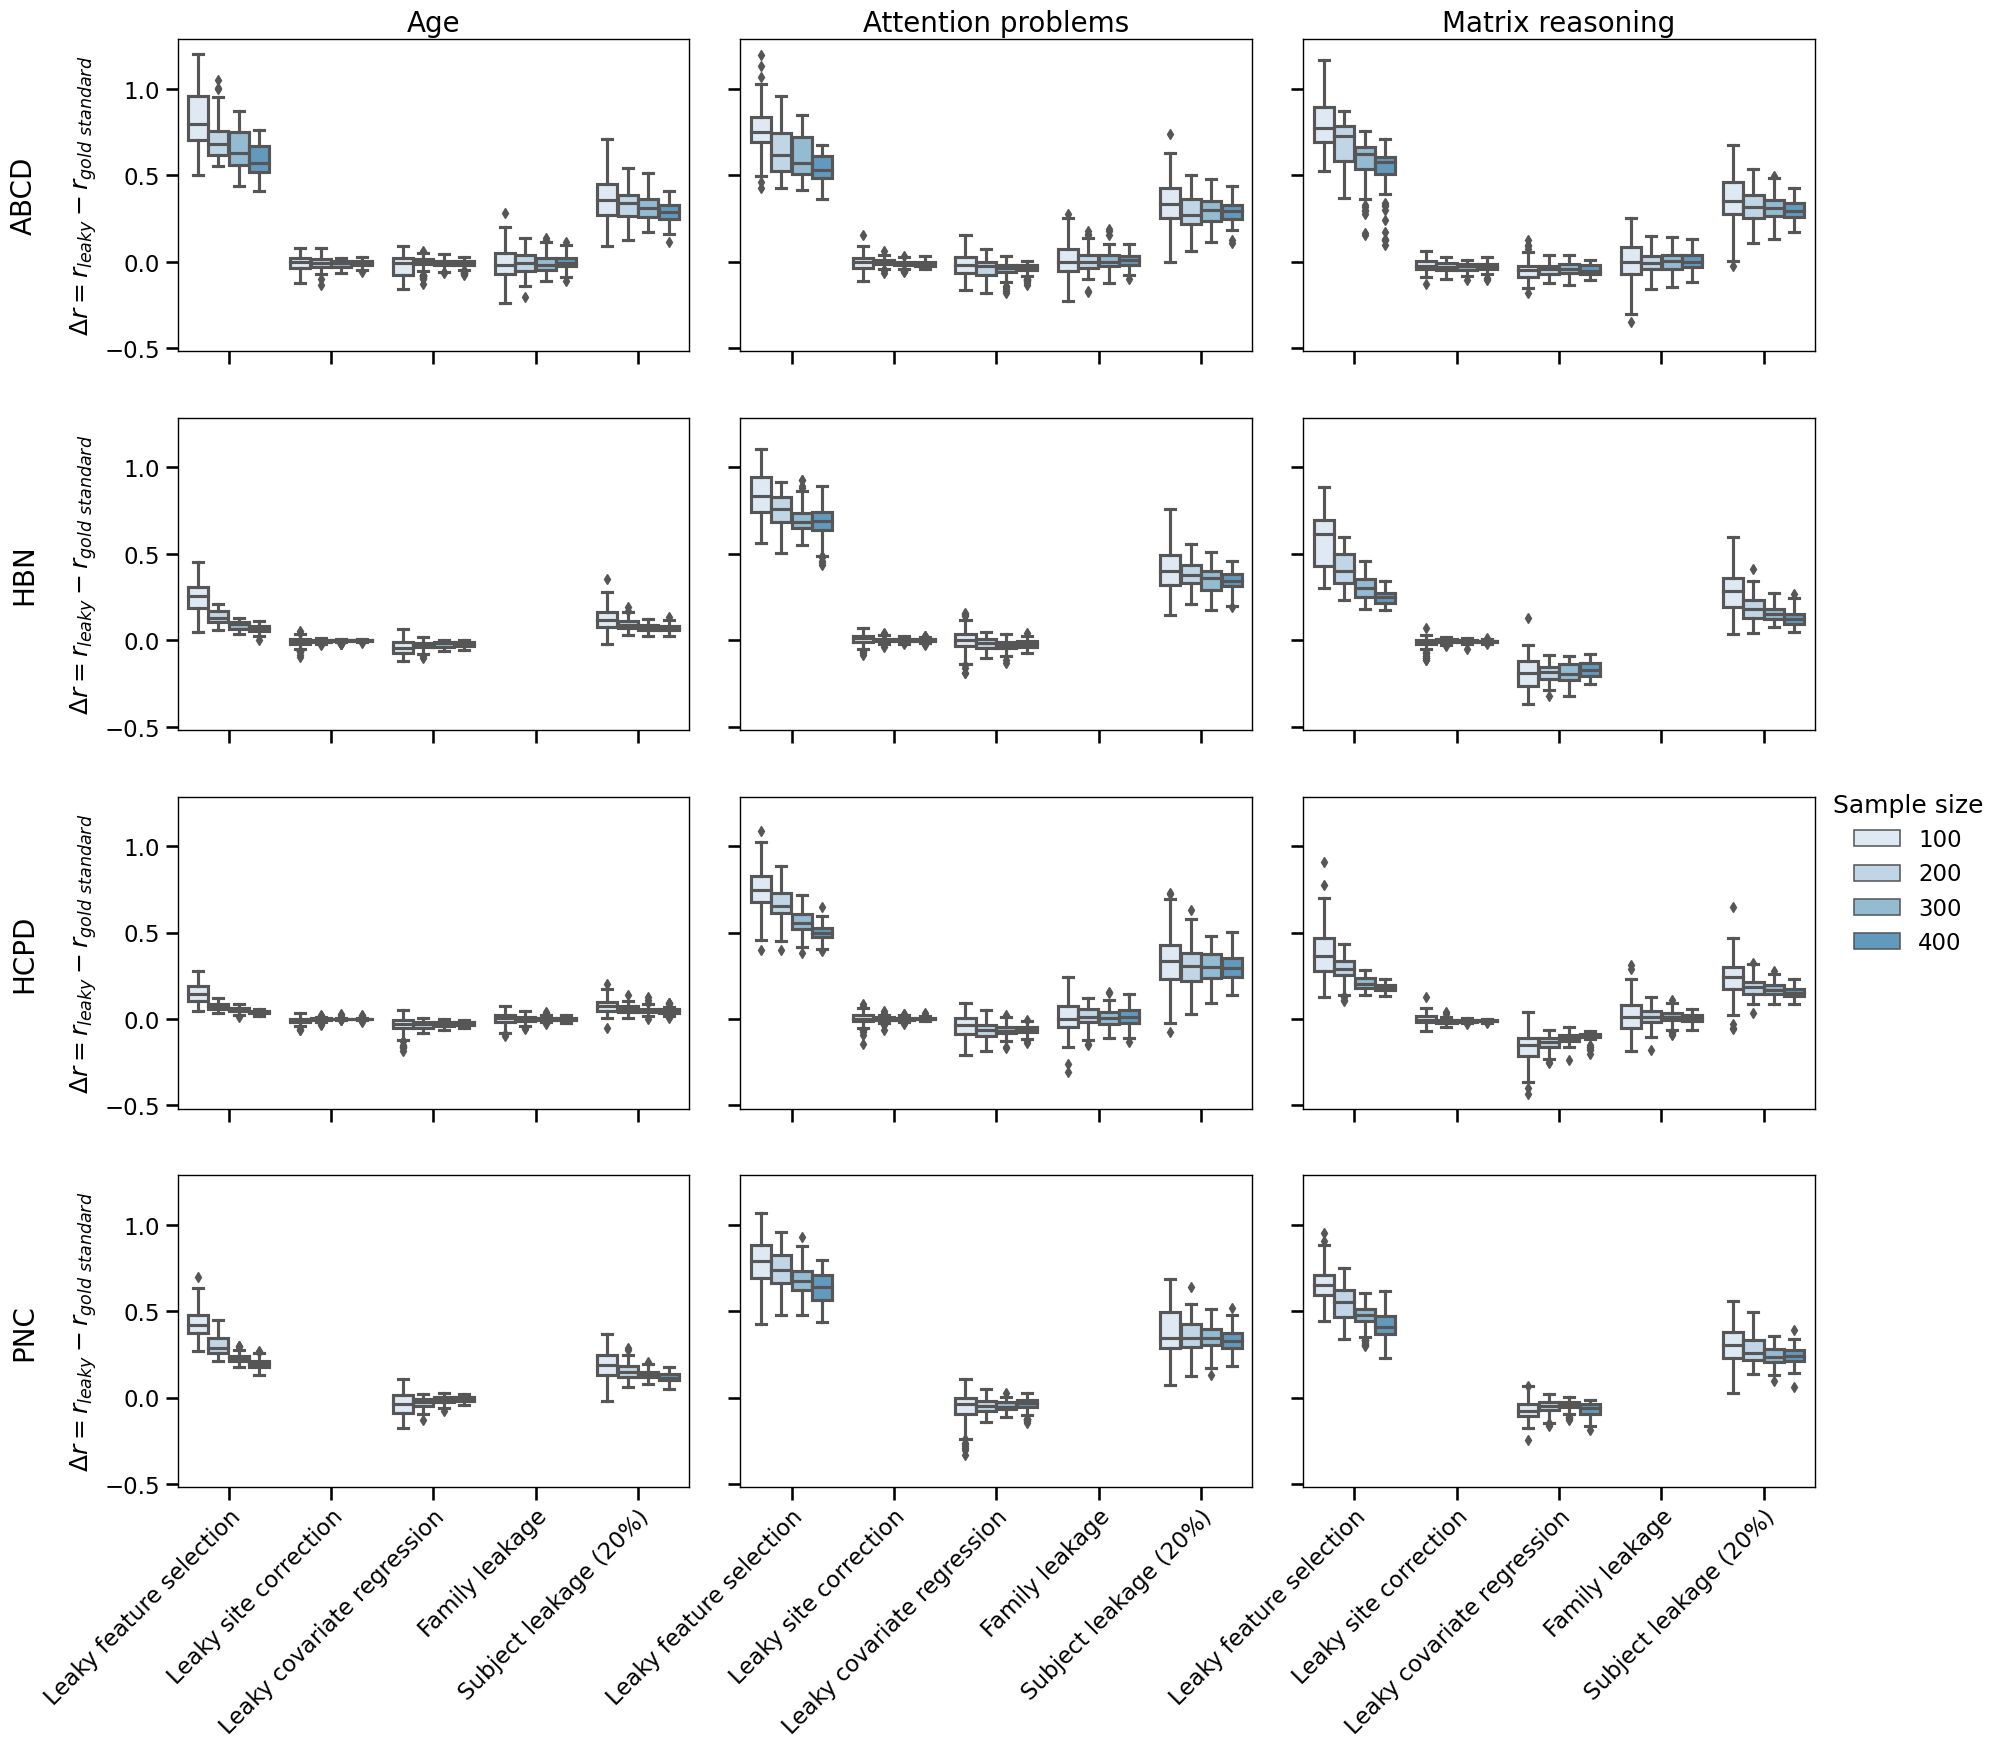

In [ ]:
'''
Plot across all k-fold and resample seeds
'''

sns.set_context('talk')
df_plot = df_all[df_all.leakage_type.isin(['leak_covars', 'leak_family', 'leak_feature', 'leak_site', 'leak_subj_20'])]


sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3, 'gold_zscore':4,
            'leak_zscore':5, 'leak_feature':6, 'leak_site':7, 'leak_covars':8, 'leak_family':9,
            'leak_subj_5':10, 'leak_subj_10':11, 'leak_subj_20':12}
all_leakage_types = [k for k in sort_dict.keys()]

rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regresion',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}

# sort it
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]

# rename columns
df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)

# rename phenotypes
df_plot['pheno'] = df_plot['pheno'].replace({'age':'Age', 'ap':'Attention problems', 'mr':'Matrix reasoning'})

leakage_types = list(df_plot.leakage_type.unique())

# for pheno in cols
g = sns.catplot(
    data=df_plot, x='leakage_type', y='r_diff', hue='sample_size',
    col='pheno', row='dataset',
    kind='box',
    palette=sns.color_palette("Blues"),
    height=4, aspect=1.5,
    order=leakage_types,
    col_order=['Age', 'Attention problems', 'Matrix reasoning'],
    row_order=['abcd', 'hbn', 'hcpd', 'pnc']
)


g.set_xticklabels(leakage_types, rotation=45, ha='right', rotation_mode='anchor')
g.set_axis_labels('', '$\Delta r = r_{leaky} - r_{gold \ standard}$')

# legend title
g.legend.set_title('Sample size')

# decrease width space (hspace for height)
g.fig.subplots_adjust(wspace=0.1)


# update axis labeling
for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip().replace('pheno = ', ''), fontsize=20)
        else:
            axes_col.set_title('')


        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(ylabel)

            axes_col.text(-0.3, 0.5, row.strip().replace('dataset = ', '').upper(),
                          fontsize=20, transform=axes_col.transAxes, rotation=90,
               horizontalalignment = 'center', verticalalignment='center')

# add box around axes
for ax in g.axes.flatten(): # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)

plt.show()



In [17]:
# take median over folds (grouped by pheno/dataset/sample size)
df_med_kfold = df_all.groupby(['pheno', 'dataset', 'sample_size', 'resample_seed', 'leakage_type'], as_index=False).\
    agg(r_diff_med_single_seed=('r_diff', 'median'),
       r_med=('r', 'median'),
       r_gold_med=('r_gold', 'median'))
df_med_kfold['r_diff_med'] = df_med_kfold['r_med'] - df_med_kfold['r_gold_med']
df_med_kfold[df_med_kfold.leakage_type=='leak_site'].sort_values('r_diff_med', ascending=False).head(5)

,pheno,dataset,sample_size,resample_seed,leakage_type,r_diff_med_single_seed,r_med,r_gold_med,r_diff_med
1133,ap,abcd,100,1,leak_site,0.051026,0.072621,0.017671,0.054951
1789,ap,hcpd,100,8,leak_site,0.041851,-0.172610,-0.217248,0.044638
2861,mr,hcpd,100,2,leak_site,0.023367,0.145596,0.105195,0.040401
1189,ap,abcd,100,8,leak_site,0.030326,-0.159265,-0.199010,0.039745
1458,ap,hbn,100,2,leak_site,0.027528,-0.104857,-0.142456,0.037598


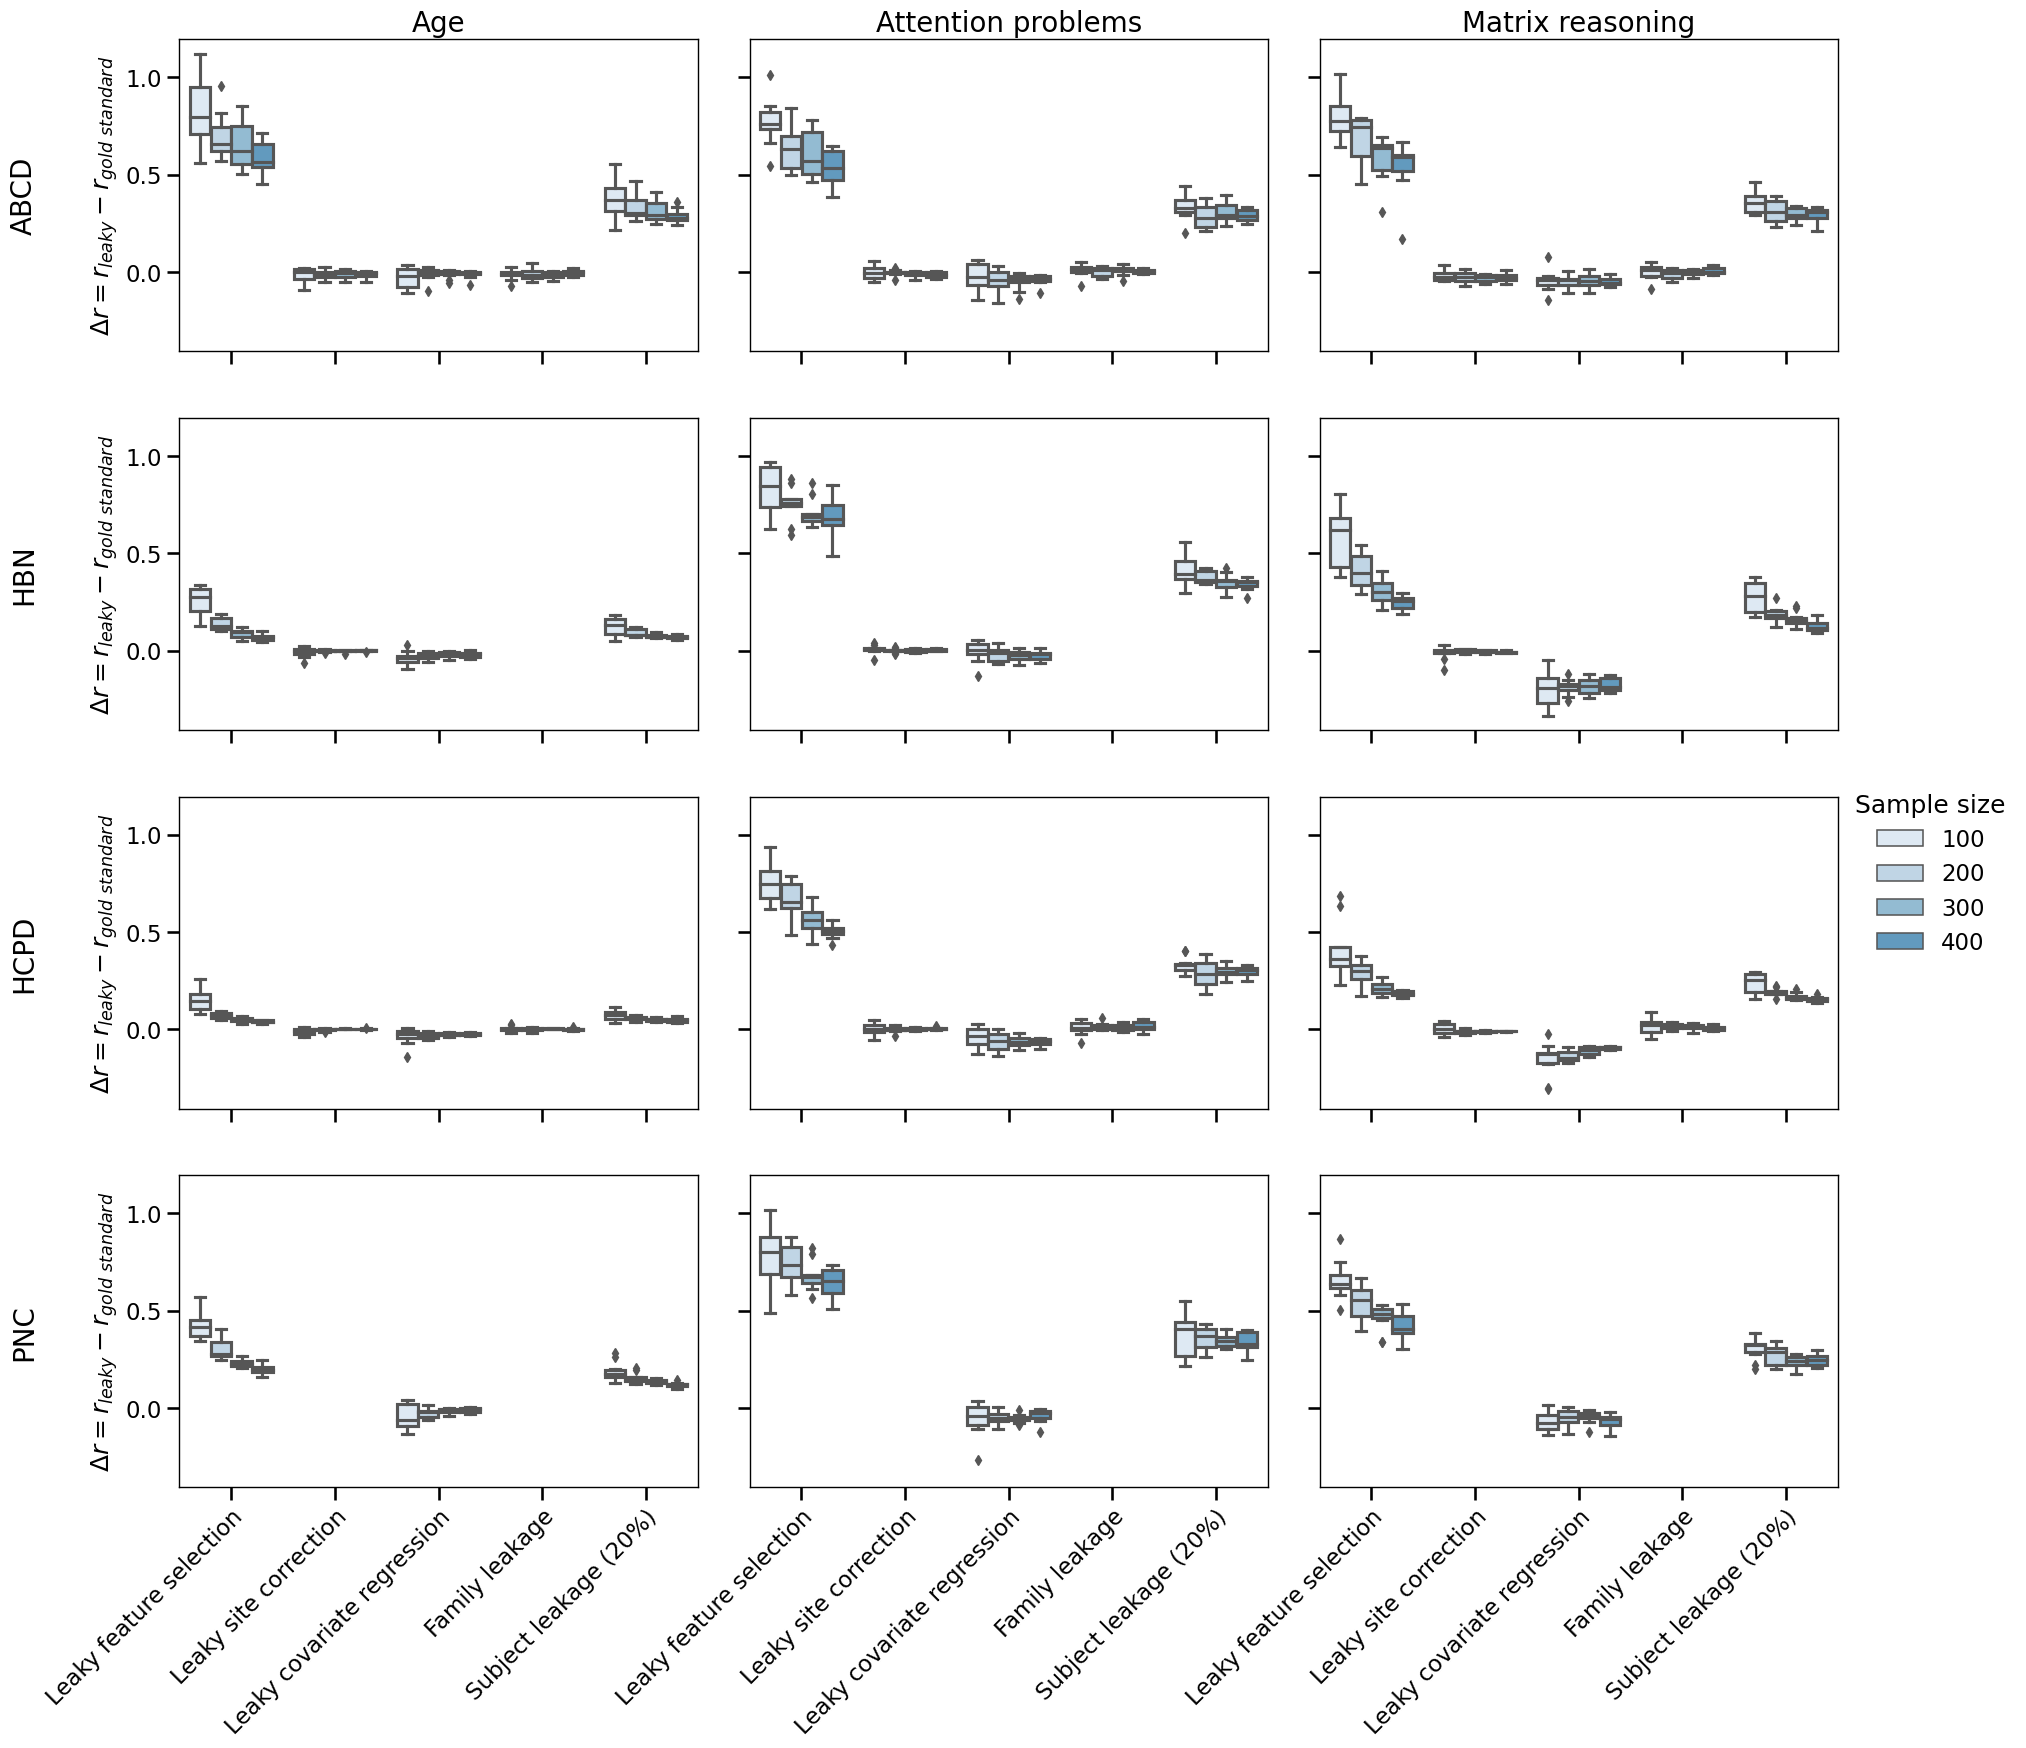

In [18]:
'''
Plot across MEDIAN of k-fold and resample seeds
'''

sns.set_context('talk')
df_plot = df_med_kfold[df_med_kfold.leakage_type.isin(['leak_covars', 'leak_family', 'leak_feature', 'leak_site', 'leak_subj_20'])]


sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3, 'gold_zscore':4,
            'leak_zscore':5, 'leak_feature':6, 'leak_site':7, 'leak_covars':8, 'leak_family':9,
            'leak_subj_5':10, 'leak_subj_10':11, 'leak_subj_20':12}
all_leakage_types = [k for k in sort_dict.keys()]

rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regresion',
               'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
               'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
               'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
               'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
            'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
               'leak_subj_20':'Subject leakage (20%)'}

# sort it
df_plot = df_plot.reset_index(drop=True)
df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]

# rename columns
df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)

# rename phenotypes
df_plot['pheno'] = df_plot['pheno'].replace({'age':'Age', 'ap':'Attention problems', 'mr':'Matrix reasoning'})

leakage_types = list(df_plot.leakage_type.unique())

# for pheno in rows
# g = sns.catplot(
#     data=df_plot, x='leakage_type', y='r_diff', hue='sample_size',
#     row='pheno', col='dataset',
#     kind='box', palette=sns.color_palette('colorblind'),
#     height=4, aspect=1.5,
#     order=leakage_types,
#     row_order=['Age', 'Attention', 'Matrix reasoning'],
#     col_order=['abcd', 'hbn', 'hcpd', 'pnc']
# )

# for pheno in cols
g = sns.catplot(
    data=df_plot, x='leakage_type', y='r_diff_med', hue='sample_size',
    col='pheno', row='dataset',
    kind='box',
    palette=sns.color_palette("Blues"),
    height=4, aspect=1.5,
    order=leakage_types,
    col_order=['Age', 'Attention problems', 'Matrix reasoning'],
    row_order=['abcd', 'hbn', 'hcpd', 'pnc']
)


g.set_xticklabels(leakage_types, rotation=45, ha='right', rotation_mode='anchor')
g.set_axis_labels('', '$\Delta r = r_{leaky} - r_{gold \ standard}$')

# legend title
g.legend.set_title('Sample size')

# decrease width space (hspace for height)
g.fig.subplots_adjust(wspace=0.1)


# update axis labeling
for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip().replace('pheno = ', ''), fontsize=20)
        else:
            axes_col.set_title('')


        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(ylabel)

            axes_col.text(-0.3, 0.5, row.strip().replace('dataset = ', '').upper(),
                          fontsize=20, transform=axes_col.transAxes, rotation=90,
               horizontalalignment = 'center', verticalalignment='center')

# add box around axes
for ax in g.axes.flatten(): # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)

plt.show()


DTI data

In [19]:
df_all = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/dti_results.csv')
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                      right_on=['leakage_type', 'dataset', 'pheno'])

# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)

df_all = df_all.sort_values('leakage_type')

In [21]:
'''
Print out some results
'''
# group by pheno and dataset to get gold standard table
df_table_gold = df_all[df_all.leakage_type=='gold'].groupby(['pheno', 'dataset'], as_index=False)\
    .agg(rmed=('r', 'median'), r2_5=('r', lambda x: calc_quantile(x, 0.025)),
         r97_5=('r', lambda x: calc_quantile(x, 0.975)),
         q2med=('q2', 'median'), q2_2_5=('q2', lambda x: calc_quantile(x, 0.025)),
         q2_97_5=('q2', lambda x: calc_quantile(x, 0.975)) )

# add in median values from OTHER leakage types to gold-standard table
all_leakage_types = df_all[df_all.leakage_type!='gold'].leakage_type.unique()
for l in all_leakage_types:
    df_tmp = df_all[df_all.leakage_type==l].groupby(['pheno', 'dataset'], as_index=False)\
    .agg(rmed=('r', 'median'),
         q2med=('q2', 'median') )

    # merge other leakage types into gold dataframe, adding a suffix with leakage type to the var name
    df_table_gold = df_table_gold.merge(df_tmp, how='left',
                    left_on=['pheno', 'dataset'], right_on=['pheno', 'dataset'],
                   suffixes=('', '_' + l))

df_table_gold = df_table_gold.rename(columns={'rmed':'rmed_gold', 'q2med':'q2med_gold'})
df_table_gold.head()

,pheno,dataset,rmed_gold,r2_5,r97_5,q2med_gold,q2_2_5,q2_97_5,rmed_gold_minus_covars,q2med_gold_minus_covars,...,rmed_leak_feature,q2med_leak_feature,rmed_leak_site,q2med_leak_site,rmed_leak_subj_10,q2med_leak_subj_10,rmed_leak_subj_20,q2med_leak_subj_20,rmed_leak_subj_5,q2med_leak_subj_5
0,age,hcpddti,0.730956,0.717437,0.743808,0.534037,0.514340,0.552234,0.784424,0.614294,...,0.805814,0.649113,0.728721,0.530395,0.762021,0.579539,0.784739,0.613236,0.747577,0.557379
1,ap,hcpddti,0.106939,0.031080,0.164048,-0.072581,-0.119711,-0.025044,0.110743,-0.071142,...,0.674551,0.444528,0.100452,-0.063437,0.257711,0.033334,0.373634,0.130927,0.190268,-0.011915
2,mr,hcpddti,0.341275,0.215053,0.400186,0.115492,0.039384,0.159386,0.271365,0.058722,...,0.515348,0.262169,0.332190,0.108289,0.393972,0.153160,0.423390,0.174670,0.376408,0.138543


<ipython-input-23-f1d1444cb46b>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-23-f1d1444cb46b>:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


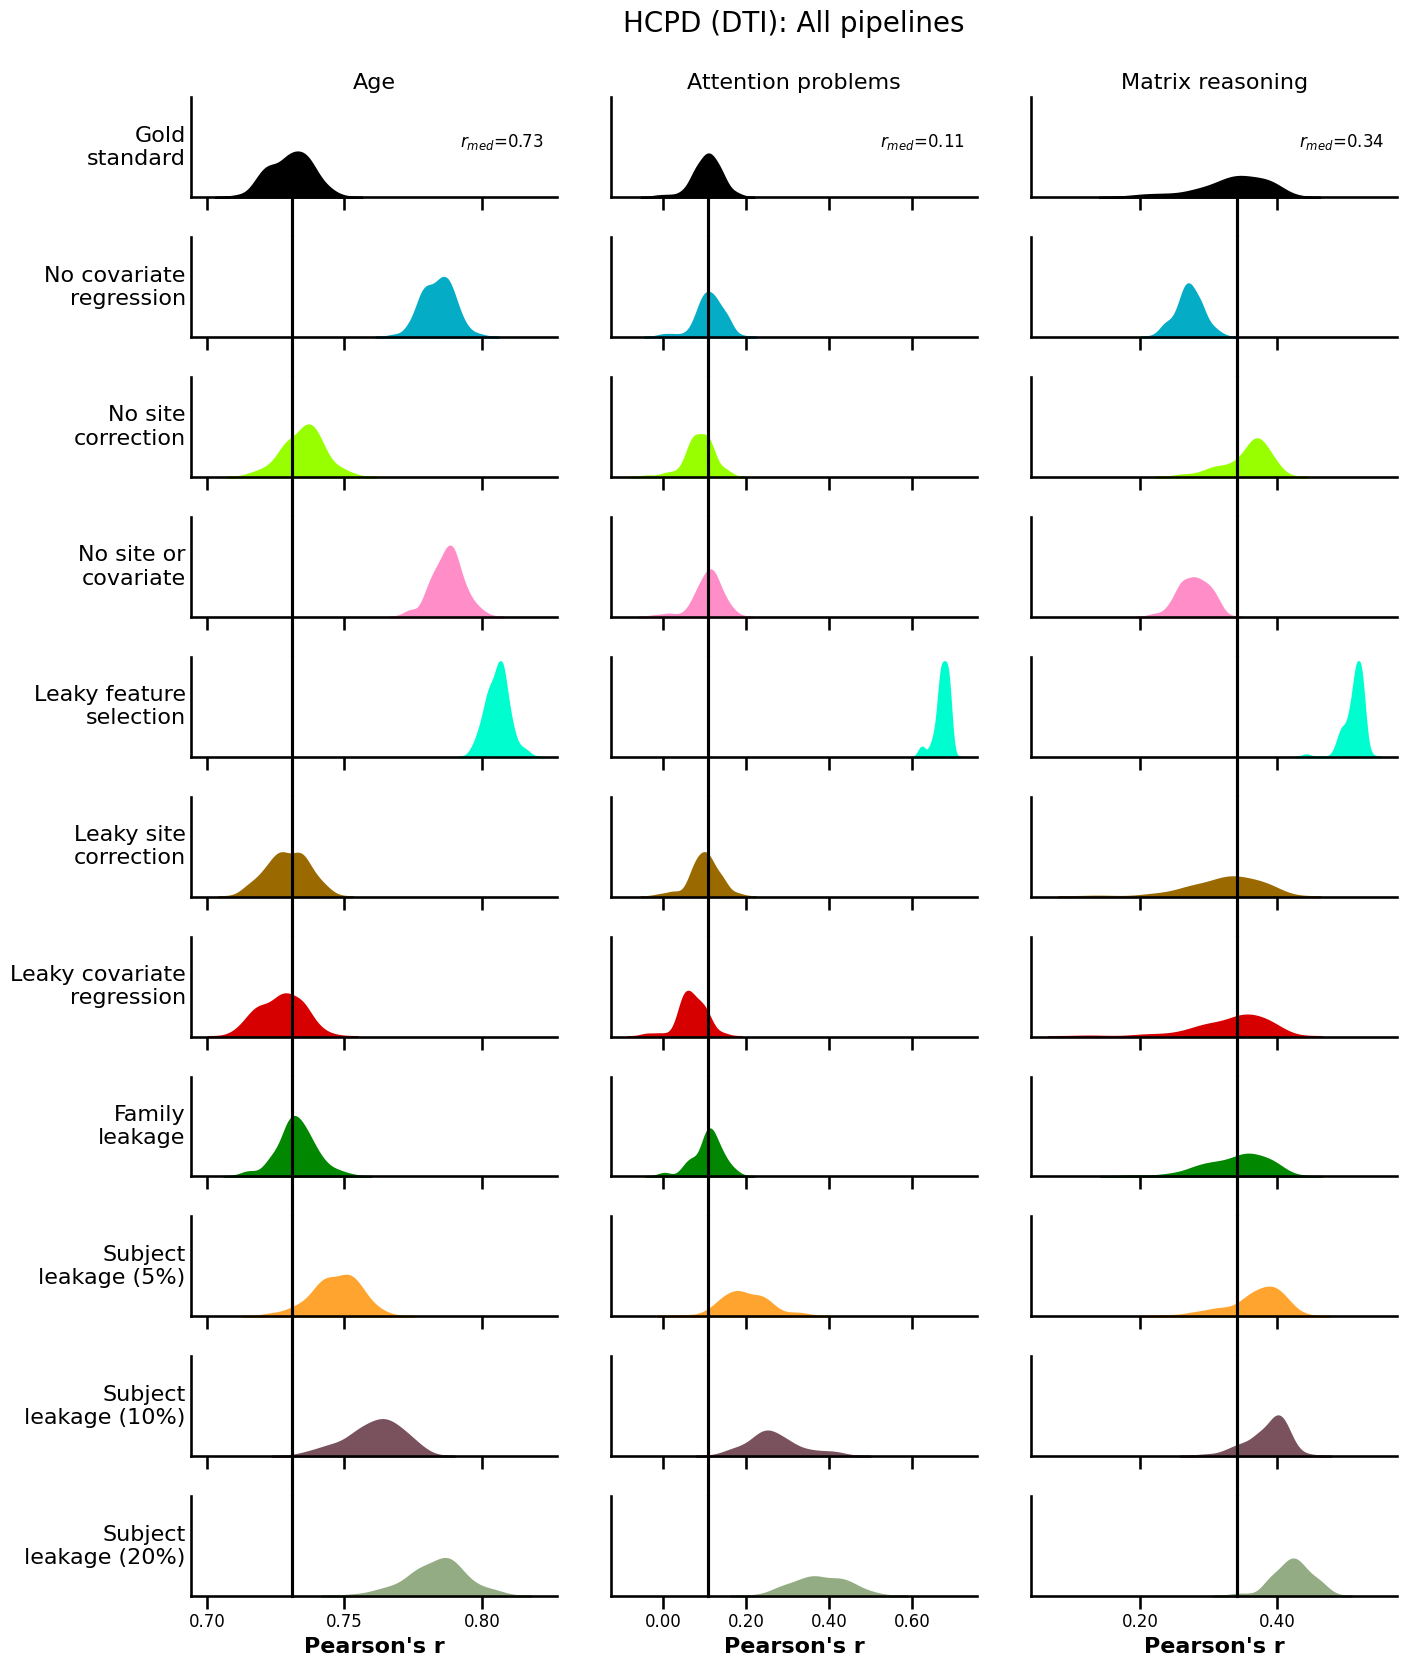

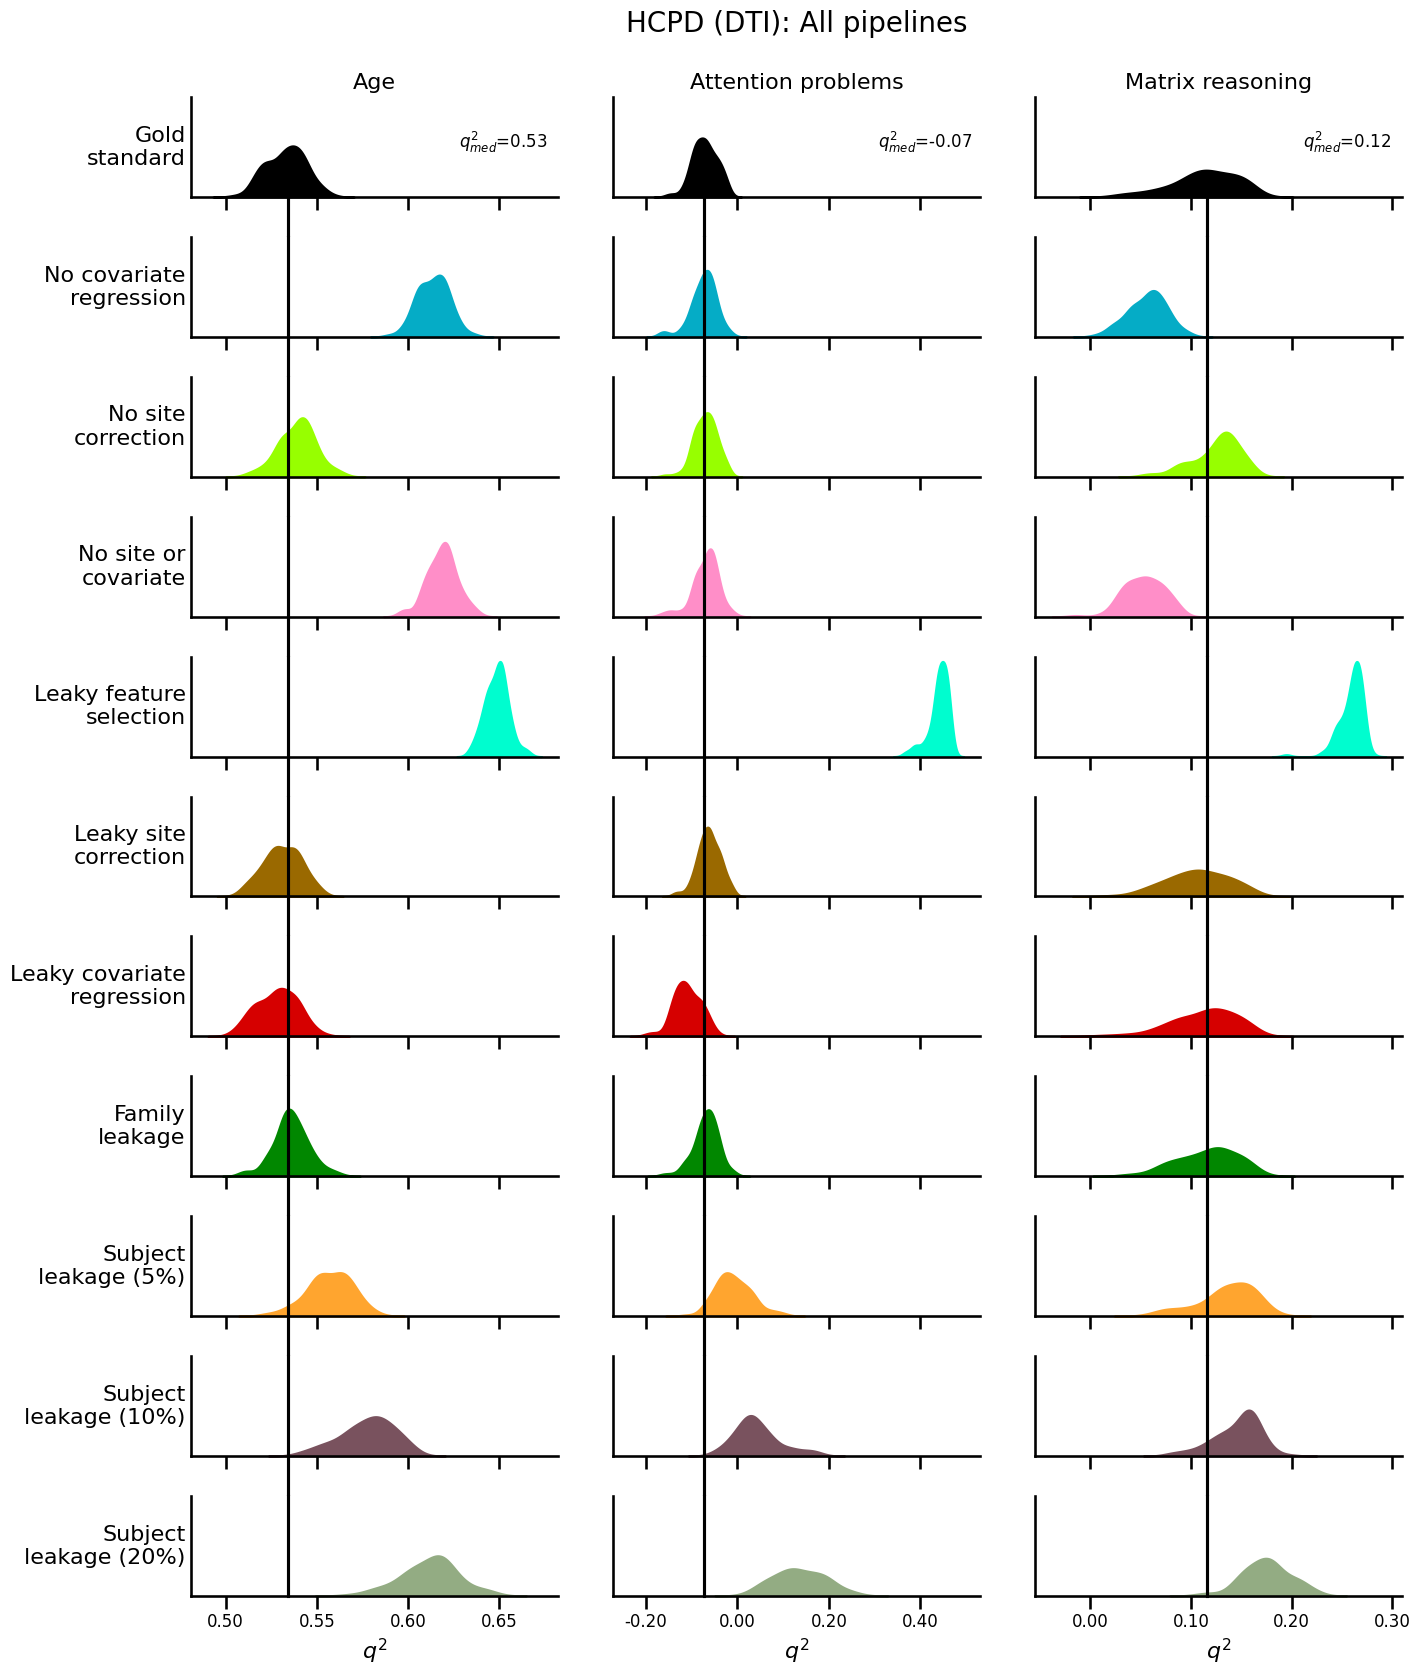

In [23]:
'''
Plots for dti results
'''

df_all['dataset'] = df_all['dataset'].replace('hcpddti', 'HCPD (DTI)')

for r_or_q2 in ['r', 'q2']:
    for dataset in ['HCPD (DTI)']:

        '''
        Copy below for all
                        'All pipelines',
                        'Feature leakage',
                        'Subject-level leakage',
                        'Covariate-related leakage',
                       'Non-leaky analysis choices'
        '''


        df_plot = df_all[(df_all.dataset==dataset)]

        # sort it
        df_plot = df_plot.reset_index(drop=True)
        df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]




        # rename
        rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
                       'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
                       'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
                       'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
                       'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
                    'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
                       'leak_subj_20':'Subject leakage (20%)'}
        df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)





        # color palette dictionary based on names
        pal_all = ['black']
        np.random.seed(4)
        cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
        color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity

        leakage_types = ['Gold standard',
                         'No covariate regression', 'No site correction',
                         'No site or covariate',
                         'Leaky feature selection',
                        'Leaky site correction', 'Leaky covariate regression',
                         'Family leakage', 'Subject leakage (5%)',
                        'Subject leakage (10%)', 'Subject leakage (20%)'

                        ]


        # restrict plot df to just leakage types of interest
        df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

        df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                    'mr':'Matrix reasoning',
                                                    'age':'Age'})

        ###################################### Actual plotting ######################################
        # palette based on smaller dataframe
        pal = [pal_dict[l] for l in leakage_types]

        # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
        plot_aspect = 3
        plot_height = 1.5
        fontsize = 16

        g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                          aspect=plot_aspect, height=plot_height,
                          palette=pal,
                          col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                          row_order=leakage_types,
                          sharex='col', sharey='col')

        # then we add the densities kdeplots f
        g.map(sns.kdeplot, r_or_q2,
              bw_adjust=1, clip_on=False,
              fill=True, alpha=1, linewidth=1.5)

        # adjust plot spacing
        g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


        for row_idx, ax_col in enumerate(g.axes):
            nrows = len(g.axes)
            for col_idx, ax in enumerate(ax_col):

                # if in first column and relevant datasets, set ylabel
                if (col_idx==0):
                    leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                    leakage_type_str = two_line_text(leakage_type_str)
                    ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

                else:
                    ax.set_ylabel('')

                # if in first row, set title
                pheno_str = ax.title.get_text().split('=')[-1].strip()
                if row_idx==0:
                    ax.set_title(pheno_str, fontsize=fontsize)
                else:
                    ax.set_title('')

                # other formatting specifications
                ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
                ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                ax.set_yticks([])

                # for last row
                if r_or_q2=='r':
                    xlab = "Pearson's r"
                else:
                    xlab = "$q^2$"
                ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

                # vertical line - the mean doesn't do anything since it's one value anyways
                gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                     (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
                if row_idx==0:
                    ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
                elif row_idx==(nrows-1):
                    ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
                else:
                    ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

                # add text to axis with median r (gold_value)
                if row_idx==0:
                    xloc = 0.85
                    yloc = 0.55

                    if r_or_q2=='r':
                        ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                                ha='center', va='center', transform=ax.transAxes,
                               fontsize=12)
                    elif r_or_q2=='q2':
                        ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                                ha='center', va='center', transform=ax.transAxes,
                               fontsize=12)


        # add in dataset title
        mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
        g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), 'All pipelines'),
                       ha='center',
                       va='top',
                       fontsize=fontsize+4,
                       fontweight=20,
                       x=mid, y=1.02)


SVR/CPM

In [25]:
# read in and add new columns
model_type = 'cpm'  # cpm, svr

if model_type=='cpm':
  csv_link = 'https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/cpm_results.csv'
elif model_type=='svr':
  csv_link = 'https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/svr_results.csv'

df_all = pd.read_csv(csv_link)

# add in grouped (e.g., mean by leakage type) information
df_grouped = df_all.groupby(['leakage_type', 'dataset', 'pheno'], as_index=False).agg(mean_r=('r', 'mean'),
                                                                                     mean_q2=('q2', 'mean'),
                                                                                     med_r=('r','median'),
                                                                                     med_q2=('q2','median'))
df_all = df_all.merge(df_grouped, how='left', left_on=['leakage_type', 'dataset', 'pheno'],
                      right_on=['leakage_type', 'dataset', 'pheno'])
# NEW: replace attention with attention problems
df_all['pheno'] = df_all['pheno'].replace('attn', 'ap')

# NEW: drop z-score
df_all = df_all[(df_all.leakage_type!='leak_zscore') &
               (df_all.leakage_type!='gold_zscore')].reset_index(drop=True)


df_all = df_all.sort_values('leakage_type')

<ipython-input-28-0e4e61bf597d>:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


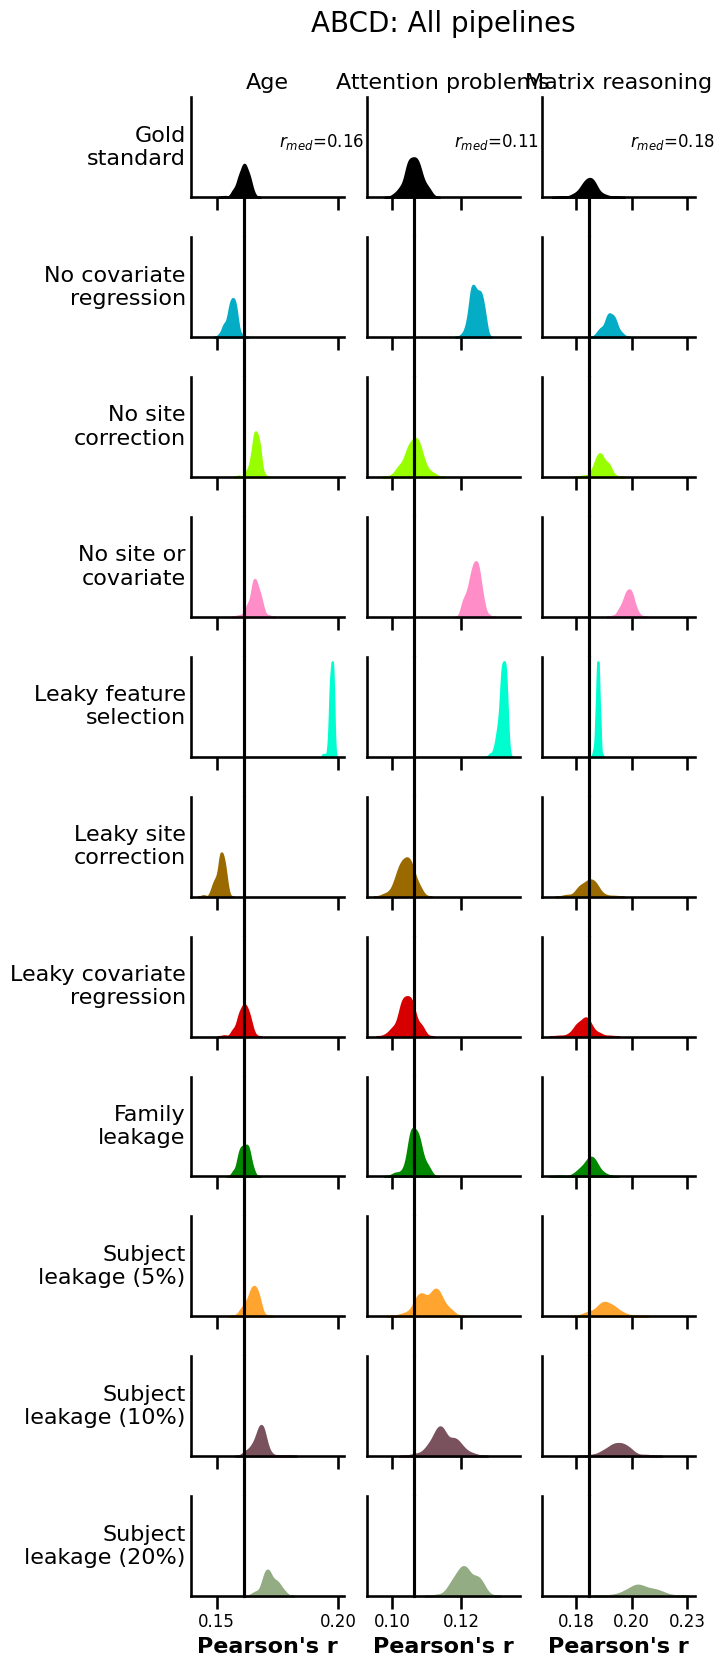

In [28]:
'''
Plots for any combination of dataset/phenotype
'''

for r_or_q2 in ['r']:
    for dataset in ['abcd']:
        for leakage_cat in ['All pipelines']:

            '''
            Copy below for all
                            'All pipelines',
                            'Feature leakage',
                            'Subject-level leakage',
                            'Covariate-related leakage',
                           'Non-leaky analysis choices'
            '''


            df_plot = df_all[(df_all.dataset==dataset)]

            # sort it for right ordering
            sort_dict = {'gold':0,'gold_minus_covars':1, 'gold_minus_site':2, 'gold_minus_site_covars':3,
                         'leak_feature':4, 'leak_site':5, 'leak_covars':6, 'leak_family':7,
                        'leak_subj_5':8, 'leak_subj_10':9, 'leak_subj_20':10}

            # add in missing keys
            all_leakage_types = [k for k in sort_dict.keys()]
            for k in sort_dict.keys():
                if k not in df_plot.leakage_type.unique():
                    print(k)
                    df_tmp = pd.DataFrame(np.nan, index=[0], columns=df_plot.keys())
                    df_tmp['dataset'] = dataset
                    df_tmp['pheno'] = np.nan
                    df_tmp['leakage_type'] = k
                    df_tmp['r'] = df_plot.r.mean()
                    df_tmp['med_r'] = np.nan
                    df_tmp['q2'] = df_plot.q2.mean()
                    df_tmp['med_q2'] = np.nan
                    df_plot = pd.concat([df_plot, df_tmp])

            # sort it
            df_plot = df_plot.reset_index(drop=True)
            df_plot = df_plot.iloc[df_plot['leakage_type'].map(sort_dict).sort_values().index]


            # rename
            rename_dict = {'gold':'Gold standard','gold_minus_covars':'No covariate regression',
                           'gold_minus_site':'No site correction', 'gold_minus_site_covars':'No site or covariate',
                           'gold_zscore':'Z-score phenotype', 'leak_zscore':'Leaky z-score',
                           'leak_feature':'Leaky feature selection', 'leak_site':'Leaky site correction',
                           'leak_covars':'Leaky covariate regression', 'leak_family':'Family leakage',
                        'leak_subj_5':'Subject leakage (5%)', 'leak_subj_10':'Subject leakage (10%)',
                           'leak_subj_20':'Subject leakage (20%)'}
            df_plot['leakage_type'] = df_plot.leakage_type.replace(rename_dict)


            # color palette dictionary based on names
            pal_all = ['black']
            np.random.seed(4)
            cmap_tmp = sns.color_palette(cc.glasbey_light, n_colors=12)
            color_shuffle_idx = np.random.permutation(len(cmap_tmp) )  # just shuffling order a bit for clarity

            if leakage_cat=='Feature leakage':
                leakage_types = ['Gold standard', 'Leaky feature selection']
            elif leakage_cat=='Subject-level leakage':
                leakage_types = ['Gold standard', 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)']
            elif leakage_cat=='Covariate-related leakage':
                leakage_types = ['Gold standard',
                                'Leaky site correction', 'Leaky covariate regression']
            elif leakage_cat=='Non-leaky analysis choices':
                leakage_types = ['Gold standard', 'No covariate regression', 'No site correction',
                                 'No site or covariate']
            elif leakage_cat=='All pipelines':
                leakage_types = ['Gold standard',
                                 'No covariate regression', 'No site correction',
                                 'No site or covariate',
                                 'Leaky feature selection',
                                'Leaky site correction', 'Leaky covariate regression',
                                 'Family leakage', 'Subject leakage (5%)',
                                'Subject leakage (10%)', 'Subject leakage (20%)'

                                ]


            # restrict plot df to just leakage types of interest
            df_plot = df_plot[df_plot['leakage_type'].isin(leakage_types)]

            df_plot['pheno'] = df_plot['pheno'].replace({'ap':'Attention problems',
                                                        'mr':'Matrix reasoning',
                                                        'age':'Age'})

            ###################################### Actual plotting ######################################
            # palette based on smaller dataframe
            pal = [pal_dict[l] for l in leakage_types]

            # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
            plot_aspect = 1.5
            plot_height = 1.5
            fontsize=16

            g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                              aspect=plot_aspect, height=plot_height,
                              palette=pal,
                              col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                              row_order=leakage_types,
                              sharex='col', sharey='col')

            # then we add the densities kdeplots f
            g.map(sns.kdeplot, r_or_q2,
                  bw_adjust=1, clip_on=False,
                  fill=True, alpha=1, linewidth=1.5)

            # adjust plot spacing
            g.fig.subplots_adjust(hspace=0.4, wspace=0.15)


            for row_idx, ax_col in enumerate(g.axes):
                nrows = len(g.axes)
                for col_idx, ax in enumerate(ax_col):

                    # if in first column and relevant datasets, set ylabel
                    if (col_idx==0) & (dataset=='abcd'):
                        leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
                        leakage_type_str = two_line_text(leakage_type_str)
                        ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')

                    else:
                        ax.set_ylabel('')

                    # if in first row, set title
                    pheno_str = ax.title.get_text().split('=')[-1].strip()
                    if row_idx==0:
                        ax.set_title(pheno_str, fontsize=fontsize)
                    else:
                        ax.set_title('')

                    # other formatting specifications
                    ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
                    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                    ax.set_yticks([])

                    # for last row
                    if r_or_q2=='r':
                        xlab = "Pearson's r"
                    else:
                        xlab = "$q^2$"
                    ax.set_xlabel(xlab, fontweight='bold', fontsize=fontsize)

                    # vertical line - the mean doesn't do anything since it's one value anyways
                    gold_value = df_plot[(df_plot.leakage_type=='Gold standard') &
                                         (df_plot.pheno==pheno_str)]['med_' + r_or_q2].mean()
                    if row_idx==0:
                        ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
                    elif row_idx==(nrows-1):
                        ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
                    else:
                        ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

                    # add text to axis with median r (gold_value)
                    if row_idx==0:
                        if leakage_cat=='Covariate-related leakage':
                            xloc = 0.175
                            yloc = 0.55
                        elif leakage_cat=='All pipelines':
                            xloc = 0.85
                            yloc = 0.55
                        else:
                            xloc = 0.89
                            yloc = 0.55

                        if r_or_q2=='r':
                            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)
                        elif r_or_q2=='q2':
                            ax.text(xloc, yloc, '$q^2_{med}$=' + '{:.2f}'.format(gold_value),
                                    ha='center', va='center', transform=ax.transAxes,
                                   fontsize=12)


            # add in dataset title
            mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
            g.fig.suptitle('{:s}: {:s}'.format(dataset.upper(), leakage_cat),
                           ha='center',
                           va='top',
                           fontsize=fontsize+4,
                           fontweight=20,
                           x=mid, y=1.02)

Twin leakage analysis

For additional behavioral measures, see: https://nda.nih.gov/data_structure.html?short_name=abcd_cbcls01

*   cbcl_scr_syn_anxdep_r
*   cbcl_scr_syn_internal_r
*   cbcl_scr_syn_external_r
*   cbcl_scr_syn_aggressive_r





In [30]:
df_pheno = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/pheno_similarity.csv')
df_results = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/twin_results.csv')

# change column entries
df_pheno['pheno'] = df_pheno['pheno'].replace('cbcl_scr_syn_anxdep_r', 'Anx/Dep').replace('cbcl_scr_syn_internal_r', 'Internal').replace('cbcl_scr_syn_external_r', 'External').replace('cbcl_scr_syn_aggressive_r', 'Aggression')
df_pheno['pheno'] = df_pheno['pheno'].replace('age', 'Age').replace('mr', 'MR').replace('attn', 'Attn')
df_results['pheno'] = df_results['pheno'].replace('cbcl_scr_syn_anxdep_r', 'Anx/Dep').replace('cbcl_scr_syn_internal_r', 'Internal').replace('cbcl_scr_syn_external_r', 'External').replace('cbcl_scr_syn_aggressive_r', 'Aggression')
df_results['pheno'] = df_results['pheno'].replace('age', 'Age').replace('mr', 'MR').replace('attn', 'Attn')
df_results['leak_twins'] = df_results['leak_twins'].apply(lambda x: 'Twin leakage' if x else 'No leakage')
df_results['model_type'] = df_results['model_type'].replace('cpm', 'CPM').replace('svr', 'SVR').replace('ridge', 'Ridge').replace('rf', 'Random Forest')
df_results = df_results.rename(columns={'leak_twins':'leakage_type'})
df_results['leakage_type'] = df_results['leakage_type'].replace('No leakage', 'Gold standard')
df_results.head()

,pheno,model_type,leakage_type,seed,r
0,Anx/Dep,Ridge,Twin leakage,0,0.055986
1,Anx/Dep,Ridge,Gold standard,0,-0.021440
2,Anx/Dep,CPM,Twin leakage,0,0.006014
3,Anx/Dep,CPM,Gold standard,0,-0.039686
4,Anx/Dep,SVR,Twin leakage,0,0.046980


['Age' 'Matrix reasoning' 'Attention problems']


<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
<ipython-input-33-84362ae93421>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize = 12)


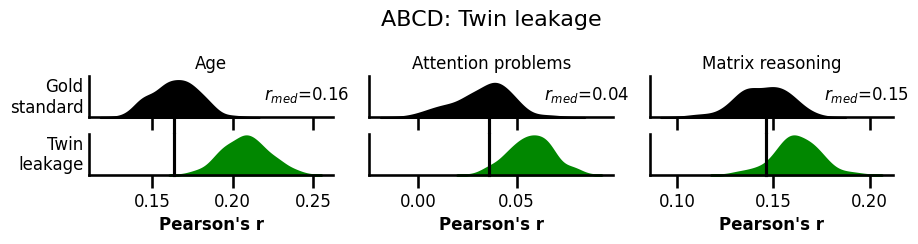

In [33]:
'''
Twin leakage plot: set model type below
'''

model_type = 'Ridge'  # which model to plot: Ridge, SVR, CPM, Random Forest

df_plot = df_results[ (df_results['model_type']==model_type) &
                     (df_results.pheno.isin(['Age', 'Attn', 'MR']))].reset_index(drop=True)


df_plot['pheno'] = df_plot['pheno'].replace('Attn', 'Attention problems').replace('MR', 'Matrix reasoning')


plot_aspect = 2.5
plot_height = 1.25
fontsize=12

print(df_plot.pheno.unique())

g = sns.FacetGrid(df_plot, row='leakage_type', col='pheno', hue='leakage_type',
                  aspect=plot_aspect, height=plot_height,
                  col_order = ['Age', 'Attention problems', 'Matrix reasoning'],
                  row_order=['Gold standard', 'Twin leakage'],
                  sharex='col', sharey='col',
                 palette=[(0.00392156862745098, 0.5294117647058824, 0.0), 'black', ])

# then we add the densities kdeplots f
g.map(sns.kdeplot, 'r',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)


# adjust plot spacing
g.fig.subplots_adjust(hspace=0.4, wspace=0.15)

for row_idx, ax_col in enumerate(g.axes):
    nrows = len(g.axes)
    for col_idx, ax in enumerate(ax_col):

        # if in first column and relevant datasets, set ylabel
        if (col_idx==0):
            leakage_type_str = re.search('leakage_type = (.*)pheno = ', ax.title.get_text()).group(1).replace('|', '').strip()
            leakage_type_str = two_line_text(leakage_type_str)
            ax.set_ylabel(leakage_type_str, fontsize=fontsize, rotation=0, ha='right', va='center')
        else:
            ax.set_ylabel('')

        # if in first row, set title
        pheno_str = ax.title.get_text().split('=')[-1].strip()
        if row_idx==0:
            ax.set_title(pheno_str, fontsize=fontsize)
        else:
            ax.set_title('')

        # other formatting specifications
        ax.set_xticklabels(ax.get_xticks(), fontsize = 12)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_yticks([])

        # for last row
        ax.set_xlabel("Pearson's r", fontweight='bold', fontsize=fontsize)

        # vertical line - the mean doesn't do anything since it's one value anyways
        gold_value = df_plot[(df_plot.leakage_type=='Gold standard') & (df_plot.pheno==pheno_str)]['r'].median()

        if row_idx==0:
            ax.axvline(x=gold_value, ymin=-1, ymax=0, color='black', linestyle='-', clip_on=False)
        elif row_idx==(nrows-1):
            ax.axvline(x=gold_value, ymin=0.0, ymax=1, color='black', linestyle='-', clip_on=False)
        else:
            ax.axvline(x=gold_value, ymin=-1, ymax=1, color='black', linestyle='-', clip_on=False)

        # add text to axis with median r (gold_value)
        if row_idx==0:
            xloc = 0.89
            yloc = 0.55

            ax.text(xloc, yloc, '$r_{med}$=' + '{:.2f}'.format(gold_value),
                    ha='center', va='center', transform=ax.transAxes,
                   fontsize=12)

    # add in dataset title
    mid = (g.fig.subplotpars.right + g.fig.subplotpars.left)/2
    _ = g.fig.suptitle('{:s}: {:s}'.format('ABCD', 'Twin leakage'),
               ha='center',
               va='top',
               fontsize=fontsize+4,
               fontweight=20,
               x=mid, y=1.05)

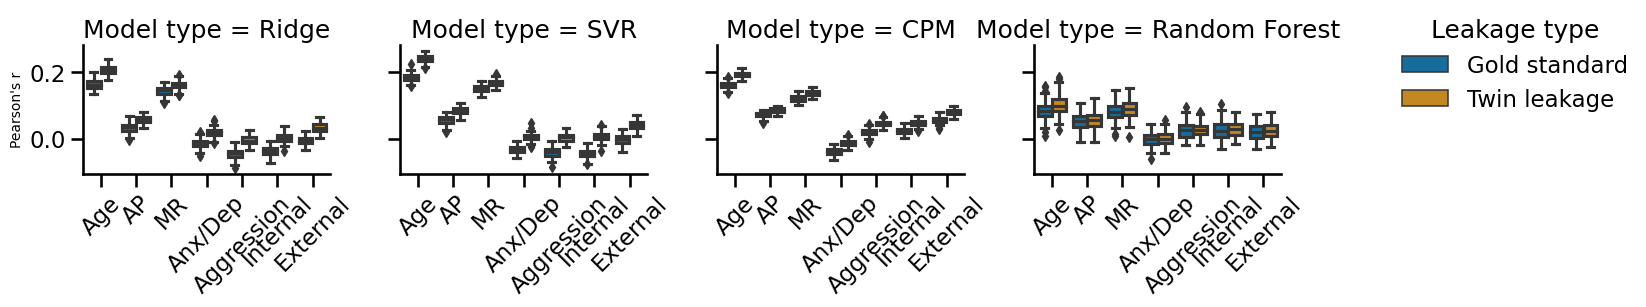

In [36]:
'''
Plot comparison of twin/no twin leakage across more models/phenotypes (supplemental figures)
'''


df_plot = df_results.copy()
pheno_order = ['Age', 'AP', 'MR', 'Anx/Dep', 'Aggression', 'Internal', 'External']
aspect = 1.2
legend_loc = (0.9, 0.975)

# fix attention problems name
df_plot['pheno'] = df_plot['pheno'].replace('Attn', 'AP')

df_plot = df_plot.rename(columns={'leakage_type':'Leakage type', 'model_type':'Model type'})

g = sns.catplot(
    data=df_plot, x='pheno', y='r', hue='Leakage type',
    col='Model type', kind='box',
    order=pheno_order,
    col_order = ['Ridge', 'SVR', 'CPM', 'Random Forest'],
    aspect=aspect, height=2.8, legend=True,
    hue_order = ['Gold standard', 'Twin leakage'],
    palette = sns.color_palette('colorblind')
)
g.set_ylabels("Pearson's r", fontsize=10)
g.set_xlabels("", fontsize=10)
_ = [plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]
sns.move_legend(g, "upper left", bbox_to_anchor=legend_loc )


In [37]:
'''
Merge results from models with phenotype similarity data
This data will be used in plot for comparing phenotype similarity and effects of leakage
'''

df_pheno['mae_percent_diff'] = (df_pheno['all_other_mae'] - df_pheno['all_twin_mae']) \
    / (0.5*(df_pheno['all_other_mae'] + df_pheno['all_twin_mae']) )
df_pheno['mae_ratio'] = df_pheno['all_twin_mae'] / df_pheno['all_other_mae']


df_results_median_tmp1 = df_results[df_results.leakage_type=='Gold standard'].groupby(['pheno',
                                                                                    'model_type'],
                                                                                   as_index=False).agg({'r':'median'})
df_results_median_tmp2 = df_results[df_results.leakage_type=='Twin leakage'].groupby(['pheno',
                                                                                    'model_type'],
                                                                                   as_index=False).agg({'r':'median'})
df_results_median = df_results_median_tmp1.merge(df_results_median_tmp2, how='left',
                                                left_on=['pheno', 'model_type'], right_on=['pheno', 'model_type'],
                                                suffixes=('_no_leakage', '_leakage'))
df_results_median['r_diff'] = df_results_median['r_leakage'] - df_results_median['r_no_leakage']
df_results_median['r_percent_diff'] = (df_results_median['r_leakage'] - df_results_median['r_no_leakage']) / \
    (0.5*(df_results_median['r_leakage'] + df_results_median['r_no_leakage']))

df_results_median.head()



,pheno,model_type,r_no_leakage,r_leakage,r_diff,r_percent_diff
0,Age,CPM,0.161199,0.194122,0.032923,0.185316
1,Age,Random Forest,0.083253,0.100284,0.017031,0.185585
2,Age,Ridge,0.163752,0.207763,0.044011,0.236927
3,Age,SVR,0.185902,0.240840,0.054939,0.257479
4,Aggression,CPM,0.021765,0.048235,0.026469,0.756266


In [38]:
df_results_pheno_merged = df_results_median.merge(df_pheno, how='left', left_on=['pheno'], right_on=['pheno'])
df_results_pheno_merged = df_results_pheno_merged.rename(columns={'model_type_no_leakage':'model_type'})
df_results_pheno_merged.head()

,pheno,model_type,r_no_leakage,r_leakage,r_diff,r_percent_diff,all_twin_mae,all_other_mae,mae_percent_diff,mae_ratio
0,Age,CPM,0.161199,0.194122,0.032923,0.185316,0.008881,0.676668,1.948182,0.013125
1,Age,Random Forest,0.083253,0.100284,0.017031,0.185585,0.008881,0.676668,1.948182,0.013125
2,Age,Ridge,0.163752,0.207763,0.044011,0.236927,0.008881,0.676668,1.948182,0.013125
3,Age,SVR,0.185902,0.240840,0.054939,0.257479,0.008881,0.676668,1.948182,0.013125
4,Aggression,CPM,0.021765,0.048235,0.026469,0.756266,2.278863,3.525395,0.429523,0.646414


Text(0.5, 1.0, 'CPM')

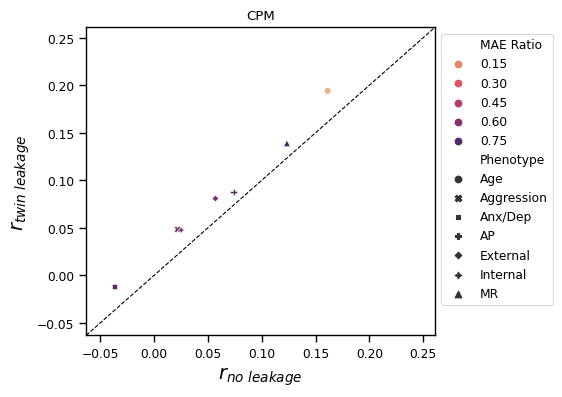

In [40]:
'''
Plot for effects of leakage compared by phenotype similarity
Change the model type below ('Ridge', 'CPM', 'SVR', 'Random Forest')
'''

plot_model='CPM'


sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4.5, 4))
df_plot = df_results_pheno_merged[df_results_pheno_merged.model_type==plot_model]
df_plot = df_plot.rename(columns={'mae_ratio':'MAE Ratio', 'pheno':'Phenotype'})  # rename columns for plot

# change attention problems name
df_plot['Phenotype'] = df_plot['Phenotype'].replace('Attn', 'AP')

min_ax_lim = np.min([df_results_pheno_merged.r_no_leakage.min(), df_results_pheno_merged.r_leakage.min()]) - 0.02
max_ax_lim = np.max([df_results_pheno_merged.r_no_leakage.max(), df_results_pheno_merged.r_leakage.max()]) + 0.02

ax.plot([min_ax_lim, max_ax_lim], [min_ax_lim, max_ax_lim], linestyle='--', color='black', lw=0.8)


sns.scatterplot(data=df_plot, x='r_no_leakage', y='r_leakage',
                hue='MAE Ratio', style='Phenotype', ax=ax,
                palette=sns.color_palette('flare', as_cmap=True) )

ax.legend(bbox_to_anchor=(1, 1))

ax.set_xlim([min_ax_lim, max_ax_lim])
ax.set_ylim([min_ax_lim, max_ax_lim])
ax.set_xlabel('$r_{no \ leakage}$', fontsize=14)
ax.set_ylabel('$r_{twin \ leakage}$', fontsize=14)
ax.set_title(plot_model)


Family leakage simulation

In [41]:
df_results = pd.read_csv('https://raw.githubusercontent.com/mattrosenblatt7/leakage_neuroimaging/main/data_for_plots/family_percentage.csv')
df_results.head()

,seed,family_percentage,leak,pheno,r
0,0,1.0,True,age,0.230146
1,0,1.0,False,age,0.227733
2,0,1.0,True,attn,0.067581
3,0,1.0,False,attn,0.047752
4,0,1.0,True,mr,0.191042


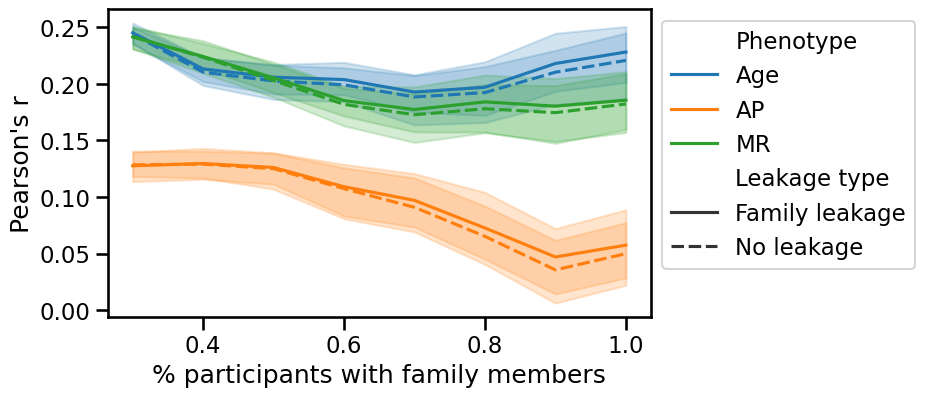

In [42]:
'''
Plot for family percentage simulation
'''
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(7, 4))

# clean up dataframe so plot labels look better
df_plot = df_results.rename(columns={'pheno':'Phenotype', 'leak':'Leakage type'})
df_plot['Leakage type'] = df_plot['Leakage type'].replace(True, 'Family leakage').replace(False, 'No leakage')
df_plot['Phenotype'] = df_plot['Phenotype'].replace('age', 'Age').replace('attn', 'AP').replace('mr', 'MR')


sns.lineplot(data=df_plot, x='family_percentage', y='r',
             hue='Phenotype', style='Leakage type', errorbar='pi',
            legend='full')

ax.set_xlabel('% participants with family members')
ax.set_ylabel("Pearson's r")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))